In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tarfile
import math
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
filename = "MovieSummaries.tar.gz"
ds = tarfile.open(filename)
print(ds.getnames())
tf = tarfile.open(filename)
tf.extractall('MS_decomp')

['MovieSummaries', 'MovieSummaries/tvtropes.clusters.txt', 'MovieSummaries/name.clusters.txt', 'MovieSummaries/plot_summaries.txt', 'MovieSummaries/README.txt', 'MovieSummaries/movie.metadata.tsv', 'MovieSummaries/character.metadata.tsv']


In [3]:
movie = pd.read_csv('./MS_decomp/MovieSummaries/'+'movie.metadata.tsv', 
                 sep='\t',
                 names=['Wikipedia_movie_ID',
                        'Freebase_movie_ID',
                        'Movie_name',
                        'Movie_release_date',
                        'Movie_box_office_revenue',
                        'Movie_runtime',
                        'Movie_languages',
                        'Movie_countries',
                        'Movie_genres'],
                 header=None)

In [4]:
character = pd.read_csv('./MS_decomp/MovieSummaries/'+'character.metadata.tsv', 
                 sep='\t',
                 names=['Wikipedia_movie_ID',
                        'Freebase_movie_ID',
                        'Movie_release_date',
                        'Character_name',
                        'Actor_date_of_birth',
                        'Actor_gender',
                        'Actor_height',
                        'Actor_ethnicity',
                        'Actor_name',
                        'Actor_age_at_movie_release',
                        'Freebase_character/actor_map_ID',
                        'Freebase_character_ID',
                        'Freebase_actor_ID'],
                 header=None)

In [5]:
plots = pd.read_csv('./MS_decomp/MovieSummaries/'+'plot_summaries.txt', 
                 sep='\t',
                 names=['Wikipedia_movie_ID',
                        'Summary'],
                 header=None)

In [6]:
movie.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [7]:
character.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


In [8]:
plots.head(3)

,Wikipedia_movie_ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...


# Data cleaning

In [9]:
#move release dates and actor birth dates to datetime format and keep only release year
character.Movie_release_date = pd.to_datetime(character['Movie_release_date'],
                                              errors='coerce').dt.year

movie.Movie_release_date = pd.to_datetime(movie['Movie_release_date'],
                                              errors='coerce').dt.year

In [10]:
#sort dataframes by ascending release year
character.sort_values(by=['Movie_release_date'], ascending=True, inplace=True)

movie.sort_values(by=['Movie_release_date'], ascending=True, inplace=True)

In [11]:
#merge dataframes
ds = pd.merge(movie,character)

In [12]:
#find movies without box office and filter them out
bad_ids = ds.loc[ds['Movie_box_office_revenue'].isnull()].index
ds_filt = ds.drop(bad_ids)

In [13]:
#sort dataframe by movie release date
#ds_filt.sort_values(by=['Movie_release_date'], ascending=True, inplace=True)

In [14]:
len(ds_filt)

101028

In [15]:
ds_filt.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
23,28703057,/m/0czdh_n,The Corbett-Fitzsimmons Fight,1897.0,100000.0,NaN,{},{},"{""/m/01z02hx"": ""Sports""}",NaN,1866-09-01,M,NaN,NaN,James J. Corbett,NaN,/m/0gvztx7,NaN,/m/037fcq
1663,1762869,/m/05tz4w,The Squaw Man,1914.0,244700.0,74.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0hfjk"": ""Weste...",NaN,1874-05-27,M,NaN,NaN,Dustin Farnum,NaN,/m/0k6jrc,NaN,/m/06x_50
1746,15340505,/m/03m5kln,Neptune's Daughter,1914.0,1000000.0,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",NaN,1887-07-06,F,NaN,NaN,Annette Kellerman,NaN,/m/040nkbv,NaN,/m/047c4t


## Preliminary results on the impact of one actor

In [16]:
#slice the character dataframe to get only Leonardo Di Caprio movies
nc = pd.DataFrame(ds_filt.query("Actor_name == 'Leonardo DiCaprio'")).reset_index(drop=True)

In [17]:
#number of movies Leonardo Di Caprio starred in
print('Leonardo Di Caprio starred in ' + str(len(nc)) + ' movies')

Leonardo Di Caprio starred in 22 movies


In [18]:
nc.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,656608,/m/0306c6,What's Eating Gilbert Grape,1993.0,10032765.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0219x_"": ""Indie"", ""/m/0clz1b"": ""Slice of ...",Arnie Grape,1974-11-11,M,1.83,/m/09kr66,Leonardo DiCaprio,NaN,/m/0k7_65,/m/02nwr_8,/m/0dvmd
1,6417754,/m/0g4lfl,This Boy's Life,1993.0,4104962.0,114.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02h8pkk"": ""Family Drama"", ""/m/04xvlr"": ""P...","Tobias ""Toby"" Wolff",1974-11-11,M,1.83,/m/09kr66,Leonardo DiCaprio,18.0,/m/0k71hy,/m/04gdr_7,/m/0dvmd
2,740824,/m/037c_d,The Quick and the Dead,1995.0,18636537.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0gw5n2f"": ""Japan...","Fee ""The Kid"" Herod",1974-11-11,M,1.83,/m/09kr66,Leonardo DiCaprio,20.0,/m/02vby_g,/m/04gdr_y,/m/0dvmd


As a preliminary analysis, we plot the distribution of box office revenues for Leonardo Di Caprio movies to see the type of distribution. From the histogram below, we observe that most of the movies have a low box office revenue (skewed distribution); the goal is to verify if there is a correlation between the 'experience' of the actor (number of times he has starred in the movie) and the revenue. 

From the box plot below it is possible to distinguish the median and the quartiles of the distribution. A couple of outliers make it difficult to visualize the distribution properly. To correctly read the data, we proceed to remove them.

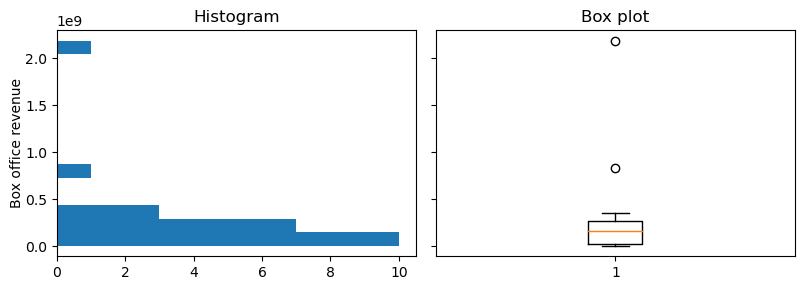

In [19]:
#plot distribution
fig, ax = plt.subplots(1,2, figsize=(8,3), sharey = True)

sbplt = ax[0]
sbplt.hist(nc.Movie_box_office_revenue, bins=15, orientation='horizontal')
sbplt.set_title('Histogram')

sbplt = ax[1]
sbplt.boxplot(nc.Movie_box_office_revenue)
sbplt.set_title('Box plot')
    
fig.tight_layout()
fig.text(0,0.3, "Box office revenue", rotation = 90)
plt.show()

In [20]:
#remove outliers
nc.query('Movie_box_office_revenue < 0.5e9', inplace=True)
nc.reset_index(inplace=True, drop=True)
print('The new number of movies considered is ' + str(len(nc)))

The new number of movies considered is 20


In this case, the distribution is way more readable. Most of the movies are in the low box office part

In [21]:
#some stats
print('The median is ' + str(np.median(nc.Movie_box_office_revenue)/1e6) + ' M$')
print('The first quartile is ' + str(np.quantile(nc.Movie_box_office_revenue,0.25)/1e6) + ' M$')
print('The third quartile is ' + str(np.quantile(nc.Movie_box_office_revenue,0.75)/1e6) + ' M$')

The median is 131.3261425 M$
The first quartile is 16.485594 M$
The third quartile is 198.76474275 M$


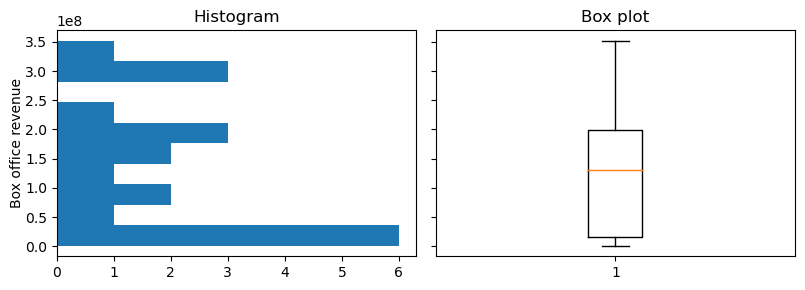

In [22]:
#plot again

fig, ax = plt.subplots(1,2, figsize=(8,3), sharey = True)

sbplt = ax[0]
sbplt.hist(nc.Movie_box_office_revenue, bins=10, orientation='horizontal')
sbplt.set_title('Histogram')

sbplt = ax[1]
sbplt.boxplot(nc.Movie_box_office_revenue)
sbplt.set_title('Box plot')
    
fig.tight_layout()
fig.text(0,0.3, "Box office revenue", rotation = 90)
plt.show()

### Actor's experience

In [23]:
#series with number of times the actor starred before (related to dataframe)
#in reality there are more movies
exp = np.zeros(len(nc)) 
t = 1
for i in range(len(nc)):
    exp[i] = t
    t += 1

In [24]:
nc['experience'] = exp #add to dataframe

In [25]:
#is there a correlation between experience and box office revenue??
stats.pearsonr(nc['experience'],nc['Movie_box_office_revenue']) #pearson correlation

PearsonRResult(statistic=0.5934248237363671, pvalue=0.00581203585134971)

In [26]:
stats.spearmanr(nc['experience'],nc['Movie_box_office_revenue'])

SpearmanrResult(correlation=0.6265513793971837, pvalue=0.0031167519062784994)

Applying the Pearson and Spearman relation, we obtain a positive correlation of **0.59** and **0.63**, respectively. This seems to lead to a link between experience and box office revenue.

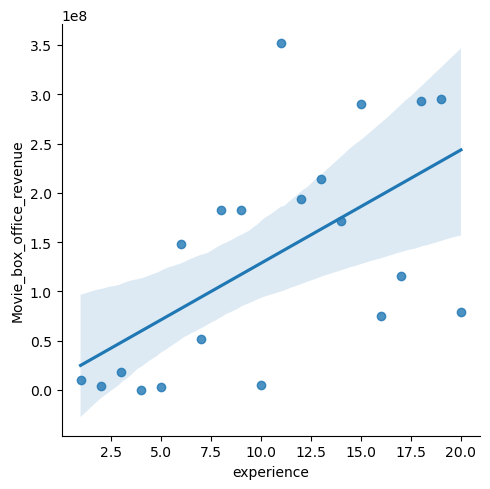

In [27]:
#plot linear correlation
sns.lmplot(x='experience',y='Movie_box_office_revenue', data=nc)
plt.show()

### Regression analysis

To understand a bit better the influence of the other parameters on the box office revenue, a model of the revenue based on multiple factors can be tested. The factors taken into consideration are:
- Movie runtime;
- Experience.

In [28]:
#copy dataframe
nc_reg = nc.copy()

In [29]:
#logarithmic scaling of continuous variables
nc_reg['Movie_box_office_revenue'] = np.log(nc_reg['Movie_box_office_revenue'])
#nc_reg['Movie_runtime'] = np.log(nc_reg['Movie_runtime'])
#nc_reg['Movie_release_date'] = np.log(nc_reg['Movie_release_date'])
#nc_reg['experience'] = np.log(nc_reg['experience'])

In [30]:
#standardize continuous variables
#nc_reg['Movie_box_office_revenue'] = (nc_reg['Movie_box_office_revenue'] - nc_reg['Movie_box_office_revenue'].mean())/nc_reg['Movie_box_office_revenue'].std()
#nc['Movie_release_date'] = (nc['Movie_release_date'] - nc['Movie_release_date'].mean())/nc['Movie_release_date'].std()
#nc['Actor_age_at_movie_release'] = (nc['Actor_age_at_movie_release'] - nc['Actor_age_at_movie_release'].mean())/nc['Actor_age_at_movie_release'].std()
#nc['experience'] = (nc['experience'] - nc['experience'].mean())/nc['experience'].std()

In [31]:
mod = smf.ols(formula='Movie_box_office_revenue ~  Movie_runtime +  experience', data=nc_reg)

res = mod.fit()
print(res.summary())

                               OLS Regression Results                               
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.524
Model:                                  OLS   Adj. R-squared:                  0.468
Method:                       Least Squares   F-statistic:                     9.360
Date:                      Thu, 10 Nov 2022   Prob (F-statistic):            0.00182
Time:                              16:06:47   Log-Likelihood:                -33.936
No. Observations:                        20   AIC:                             73.87
Df Residuals:                            17   BIC:                             76.86
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

From the results, it is possible to get interesting information. The R squared is **0.52**, meaning more than half of the variance is explained. The movie runtime (**C=0.03**) and the experience of the actor (**C=0.174**) positively influence the revenue, even if only the latter is statistically significant (**P < 5%**).
A confounder that could naively lead us to overestimate the statistical significance of the actor's experience is inflation. Indeed, over the years the value of money changes; for a proper evaluation, an inflation correction has to be done.

In [32]:
#take inflation into account
#https://liberalarts.oregonstate.edu/spp/polisci/faculty-staff/robert-sahr/inflation-conversion-factors-years-1774-estimated-2024-dollars-recent-years/individual-year-conversion-factor-table-0
cf = pd.read_csv('inflation_correction.csv')
cf.query('Year > 1969', inplace=True)
cf.reset_index(drop=True, inplace=True)
#cf['Year'] = pd.to_datetime(pd.Series(cf.Year)).dt.year #convert to datetime format

In [33]:
cf.head(3)

,Year,CF
0,1970.0,0.16
1,1971.0,0.17
2,1972.0,0.17


In [34]:
#function to compute inflation for a certain year
def infl(year):
    inf = cf['CF'][cf['Year'] == year]
    return inf

In [35]:
#compute inflation for dataframe rows and add column
infl_corr = np.zeros(len(nc))
for i in range(len(nc)):
    infl_corr[i] = infl(nc['Movie_release_date'][i])
nc['CF'] = infl_corr

In [36]:
#add inflation corrected box office revenue
nc['inflation_revenue'] = nc['Movie_box_office_revenue']/nc['CF']

In [37]:
nc.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,...,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID,experience,CF,inflation_revenue
0,656608,/m/0306c6,What's Eating Gilbert Grape,1993.0,10032765.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0219x_"": ""Indie"", ""/m/0clz1b"": ""Slice of ...",Arnie Grape,...,1.83,/m/09kr66,Leonardo DiCaprio,NaN,/m/0k7_65,/m/02nwr_8,/m/0dvmd,1.0,0.60,1.672128e+07
1,6417754,/m/0g4lfl,This Boy's Life,1993.0,4104962.0,114.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02h8pkk"": ""Family Drama"", ""/m/04xvlr"": ""P...","Tobias ""Toby"" Wolff",...,1.83,/m/09kr66,Leonardo DiCaprio,18.0,/m/0k71hy,/m/04gdr_7,/m/0dvmd,2.0,0.60,6.841603e+06
2,740824,/m/037c_d,The Quick and the Dead,1995.0,18636537.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0gw5n2f"": ""Japan...","Fee ""The Kid"" Herod",...,1.83,/m/09kr66,Leonardo DiCaprio,20.0,/m/02vby_g,/m/04gdr_y,/m/0dvmd,3.0,0.64,2.911959e+07


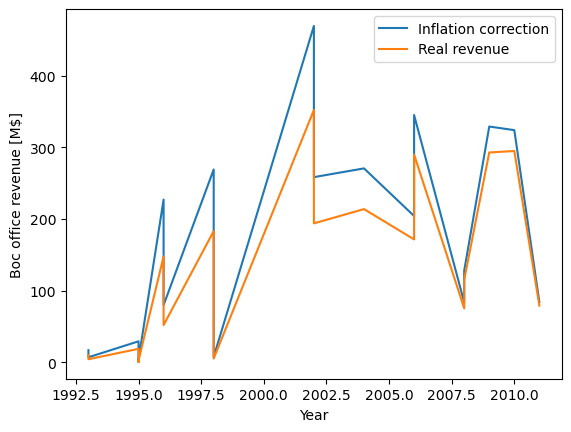

In [38]:
#compare the new revenues
plt.plot(nc.Movie_release_date, nc.inflation_revenue/1e6, label='Inflation correction')
plt.plot(nc.Movie_release_date, nc.Movie_box_office_revenue/1e6, label='Real revenue')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Boc office revenue [M$]')
plt.show()

In [39]:
#run the least mean squares again
nc_reg2 = nc.copy()
#logarithmic scaling of continuous variables
nc_reg2['inflation_revenue'] = np.log(nc_reg2['inflation_revenue'])
#nc_reg2['Movie_runtime'] = np.log(nc_reg2['Movie_runtime'])
#nc_reg2['Movie_release_date'] = np.log(nc_reg2['Movie_release_date'])
#nc_reg2['experience'] = np.log(nc_reg2['experience'])

In [40]:
mod = smf.ols(formula='inflation_revenue ~ Movie_runtime + experience', data=nc_reg2)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      inflation_revenue   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     7.645
Date:                Thu, 10 Nov 2022   Prob (F-statistic):            0.00428
Time:                        16:06:48   Log-Likelihood:                -33.991
No. Observations:                  20   AIC:                             73.98
Df Residuals:                      17   BIC:                             76.97
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.5397      1.973      6.357

From the new results above, it is possible to confirm the statistical significance of the experience on the box office (**P < 5%**), even if its influence has decreased (**C=0.148**), due to inflation.

We can go further in the analysis, by investigating the gender equality/inequality in the movies to see if they are related to revenue as well. The eventual goal would be to establish the benefit of choosing an actor over another one, and so a gender study is fundamental for this purpose.

To have some preliminary results on a single sample, the analysis will regard one of the previously studied Leonardo Di Caprio movies.

In [59]:
ds.iloc[246888]

Wikipedia_movie_ID                                                           5169996
Freebase_movie_ID                                                          /m/0d61px
Movie_name                                                  The Man in the Iron Mask
Movie_release_date                                                            1998.0
Movie_box_office_revenue                                                 182968902.0
Movie_runtime                                                                  132.0
Movie_languages                                   {"/m/02h40lc": "English Language"}
Movie_countries                    {"/m/09c7w0": "United States of America", "/m/...
Movie_genres                       {"/m/03btsm8": "Action/Adventure", "/m/07s9rl0...
Character_name                                                              Philippe
Actor_date_of_birth                                                       1974-11-11
Actor_gender                                                     

In [58]:
ds.iloc[246887]

Wikipedia_movie_ID                                                           5169996
Freebase_movie_ID                                                          /m/0d61px
Movie_name                                                  The Man in the Iron Mask
Movie_release_date                                                            1998.0
Movie_box_office_revenue                                                 182968902.0
Movie_runtime                                                                  132.0
Movie_languages                                   {"/m/02h40lc": "English Language"}
Movie_countries                    {"/m/09c7w0": "United States of America", "/m/...
Movie_genres                       {"/m/03btsm8": "Action/Adventure", "/m/07s9rl0...
Character_name                                                        King Louis XIV
Actor_date_of_birth                                                       1974-11-11
Actor_gender                                                     

In [62]:
nc_movies = [ds_filt['Movie_name'][ds_filt['Actor_name'] == 'Leonardo DiCaprio']]

In [79]:
nc_movies

[215642    What's Eating Gilbert Grape
 216960                This Boy's Life
 226571         The Quick and the Dead
 227129                  Total Eclipse
 227807         The Basketball Diaries
 234889                 Romeo + Juliet
 237281                  Marvin's Room
 244031                        Titanic
 246887       The Man in the Iron Mask
 246888       The Man in the Iron Mask
 247246                      Celebrity
 289640            Catch Me If You Can
 295084              Gangs of New York
 319253                    The Aviator
 335948                  Blood Diamond
 348740                   The Departed
 373286             Revolutionary Road
 377229                   Body of Lies
 393376                        G-Force
 409012                      Inception
 412706                 Shutter Island
 423176                       J. Edgar
 Name: Movie_name, dtype: object]

In [ ]:
n.groupby('date_transformed').apply(lambda x: pd.Series({'ctr1': x['ctr1'].values })) 

In [83]:
for i in nc_movies:
    np.concatenate(ds_filt.groupby('Movie_name').get_group(i)['Actor_name'])

247238      Kenneth Branagh
247239       Adrian Grenier
247240      Charlize Theron
247241        Aida Turturro
247242         Celia Weston
247243       Allison Janney
247244          Hank Azaria
247245      Ian Somerhalder
247246    Leonardo DiCaprio
247247        Bebe Neuwirth
247248        Famke Janssen
247249         Joe Mantegna
247250       Michael Lerner
247251        Isaac Mizrahi
247252           Judy Davis
247253         Gretchen Mol
247254         Sam Rockwell
247255        J. K. Simmons
247256           Erica Jong
247257         Winona Ryder
247258     Melanie Griffith
247259          Kate Burton
Name: Actor_name, dtype: object

In [ ]:
ds_filt.groupby('Movie_name').filter(lambda g: g['Actor_name'] == 'Leonardo Di Caprio')

In [ ]:
ds_filt

In [ ]:
dt = pd.DataFrame(ds.groupby('Movie_name')['Actor_name'].count())

In [ ]:
dt.head(50)